## Training

In [1]:
import os
import scipy.io
import pickle
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

from spectral.io import envi
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
bands = [
 1.001350, 1.007900, 1.014450, 1.021000, 1.027550, 1.034100, 1.040650,
 1.047200, 1.053750, 1.060300, 1.066850, 1.073410, 1.079960, 1.086510,
 1.093070, 1.099620, 1.106170, 1.112730, 1.119280, 1.125840, 1.132390,
 1.138950, 1.145510, 1.152060, 1.158620, 1.165180, 1.171730, 1.178290,
 1.184850, 1.191410, 1.197970, 1.204530, 1.211090, 1.217650, 1.224210,
 1.230770, 1.237330, 1.243890, 1.250450, 1.257010, 1.263570, 1.270140,
 1.276700, 1.283260, 1.289830, 1.296390, 1.302950, 1.309520, 1.316080,
 1.322650, 1.329210, 1.335780, 1.342340, 1.348910, 1.355480, 1.362050,
 1.368610, 1.375180, 1.381750, 1.388320, 1.394890, 1.401450, 1.408020,
 1.414590, 1.421160, 1.427730, 1.434310, 1.440880, 1.447450, 1.454020,
 1.460590, 1.467160, 1.473740, 1.480310, 1.486880, 1.493460, 1.500030,
 1.506610, 1.513180, 1.519760, 1.526330, 1.532910, 1.539480, 1.546060,
 1.552640, 1.559210, 1.565790, 1.572370, 1.578950, 1.585520, 1.592100,
 1.598680, 1.605260, 1.611840, 1.618420, 1.625000, 1.631580, 1.638160,
 1.644740, 1.651330, 1.657910, 1.664490, 1.671070, 1.677660, 1.684240,
 1.690820, 1.697410, 1.703990, 1.710580, 1.717160, 1.723750, 1.730330,
 1.736920, 1.743510, 1.750090, 1.756680, 1.763270, 1.769850, 1.776440,
 1.783030, 1.789620, 1.796210, 1.802800, 1.809390, 1.815980, 1.822570,
 1.829160, 1.835750, 1.842340, 1.848930, 1.855520, 1.862120, 1.868710,
 1.875300, 1.881900, 1.888490, 1.895080, 1.901680, 1.908270, 1.914870,
 1.921460, 1.928060, 1.934650, 1.941250, 1.947850, 1.954440, 1.961040,
 1.967640, 1.974240, 1.980840, 1.987430, 1.994030, 2.000630, 2.007230,
 2.013830, 2.020430, 2.027030, 2.033630, 2.040240, 2.046840, 2.053440,
 2.060040, 2.066640, 2.073250, 2.079850, 2.086450, 2.093060, 2.099660,
 2.106270, 2.112870, 2.119480, 2.126080, 2.132690, 2.139300, 2.145900,
 2.152510, 2.159120, 2.165720, 2.172330, 2.178940, 2.185550, 2.192160,
 2.198770, 2.205380, 2.211990, 2.218600, 2.225210, 2.231820, 2.238430,
 2.245040, 2.251650, 2.258270, 2.264880, 2.271490, 2.278100, 2.284720,
 2.291330, 2.297950, 2.304560, 2.311180, 2.317790, 2.324410, 2.331020,
 2.337640, 2.344260, 2.350870, 2.357490, 2.364110, 2.370720, 2.377340,
 2.383960, 2.390580, 2.397200, 2.403820, 2.410440, 2.417060, 2.423680,
 2.430300, 2.436920, 2.443540, 2.450170, 2.456790, 2.463410, 2.470030,
 2.476660, 2.483280, 2.489900, 2.496530, 2.503120, 2.509720, 2.516320,
 2.522920, 2.529510, 2.536110, 2.542710, 2.549310, 2.555910, 2.562510,
 2.569110, 2.575710, 2.582310, 2.588910, 2.595510, 2.602120, 2.608720,
 2.615320, 2.621920, 2.628530, 2.635130, 2.641740, 2.648340, 2.654950,
 2.661550, 2.668160, 2.674760, 2.681370, 2.687980, 2.694580, 2.701190,
 2.760680, 2.767290, 2.773900, 2.780520, 2.787130, 2.793740, 2.800350,
 2.806970, 2.813580, 2.820200, 2.826810, 2.833430, 2.840040, 2.846660,
 2.853280, 2.859890, 2.866510, 2.873130, 2.879750, 2.886360, 2.892980,
 2.899600, 2.906220, 2.912840, 2.919460, 2.926080, 2.932700, 2.939320,
 2.945950, 2.952570, 2.959190, 2.965810, 2.972440, 2.979060, 2.985680,
 2.992310, 2.998930, 3.005560, 3.012180, 3.018810, 3.025440, 3.032060,
 3.038690, 3.045320, 3.051950, 3.058570, 3.065200, 3.071830, 3.078460,
 3.085090, 3.091720, 3.098350, 3.104980, 3.111610, 3.118250, 3.124880,
 3.131510, 3.138140, 3.144780, 3.151410, 3.158040, 3.164680, 3.171310,
 3.177950, 3.184580, 3.191220, 3.197850, 3.204490, 3.211130, 3.217760,
 3.224400, 3.231040, 3.237680, 3.244320, 3.250960, 3.257600, 3.264240,
 3.270880, 3.277520, 3.284160, 3.290800, 3.297440, 3.304080, 3.310730,
 3.317370, 3.324010, 3.330660, 3.337300, 3.343950, 3.350590, 3.357240,
 3.363880, 3.370530, 3.377170, 3.383820, 3.390470, 3.397120, 3.403760,
 3.410410, 3.417060, 3.423710, 3.430360, 3.437010, 3.443660, 3.450310,
 3.456960, 3.463610, 3.470260, 3.476920, 3.483570, 3.490220, 3.496870,
 3.503530, 3.510180, 3.516840, 3.523490, 3.530150, 3.536800, 3.543460,
 3.550110, 3.556770, 3.563430, 3.570080, 3.576740, 3.583400, 3.590060,
 3.596720, 3.603380, 3.610040, 3.616700, 3.623360, 3.630020, 3.636680,
 3.643340, 3.650000, 3.656670, 3.663330, 3.669990, 3.676650, 3.683320,
 3.689980, 3.696650, 3.703310, 3.709980, 3.716640, 3.723310, 3.729980,
 3.736640, 3.743310, 3.749980, 3.756650, 3.763310, 3.769980, 3.776650,
 3.783320, 3.789990, 3.796660, 3.803330, 3.810000, 3.816670, 3.823350,
 3.830020, 3.836690, 3.843360, 3.850040, 3.856710, 3.863390, 3.870060,
 3.876730, 3.883410, 3.890080, 3.896760, 3.903440, 3.910110, 3.916790,
 3.923470, 3.930150, 3.936820, 4.000000]
num_bands = len(bands)

In [3]:
# Load .mat file
data_a = scipy.io.loadmat('datasets/CRISM_bland_unratioed.mat')
data_b = scipy.io.loadmat('datasets/CRISM_labeled_pixels_ratioed.mat')

im_names_a = []                               # list of CRISM image names, mapping to numerical ID
for id in data_a['im_names'].flatten():
    im_names_a.append(id[0][:5])
im_names_a = np.array(im_names_a).reshape(340, 1)
pixims_a = data_a['pixims']                   # numerical ID of the original image
coordinates_a = data_a['pixcrds']             # (x,y) point coordinates in the original image
spectra_a = data_a['pixspec']                 # unratioed spectra

im_names_b = data_b['im_names']
pixims_b = data_b['pixims']
coordinates_b = data_b['pixcrds']
spectra_b = data_b['pixspec']
labels_b = data_b['pixlabs']

In [4]:
def create_image_paths(directory_path):
    image_paths = {}
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.hdr'):
                id = file[6:11]
                image_paths[id] = os.path.join(root, file)
    return image_paths

def crism_to_mat(fname):

    img = envi.open(fname)

    arr = img.load()

    mdict = {'IF': arr}
   
    xx_, yy_ = np.meshgrid(np.arange(arr.shape[1]),
                           np.arange(arr.shape[0]))
    mdict.update({'x': xx_.ravel() + 1, 'y': yy_.ravel() + 1})
    mdict['IF'] = mdict['IF'].reshape((-1, num_bands))

    return mdict

def filter_bad_pixels(pixspec):

    pixspec = pixspec.copy()

    bad = (pixspec > 1e3) | ~np.isfinite(pixspec)
    if np.any(bad):
        pixspec[bad] = np.mean(pixspec[~bad])

    return pixspec

In [5]:
def remove_spikes_column(mat, image, window_size):

    height = np.max(mat['y'])
    width = np.max(mat['x'])
    num_channels = len(mat['IF'][0])
    
    image = image.reshape(height, width, num_channels)
    
    result = np.empty((height, width, num_channels))
    
    for col in range(width):
            column_channel = image[:, col, ch]
            
            filtered_column_channel = medfilt(column_channel, kernel_size=window_size)
            
            diff = np.abs(column_channel - filtered_column_channel)
            
            std_diff = np.std(diff)
            
            spikes = diff > 5 * std_diff

            column_channel[spikes] = filtered_column_channel[spikes]
            
            result[:, col, ch] = column_channel
            
    return result.reshape(-1, num_bands)

In [6]:
exclude = ['02885', '07E26', '0B385', '0C26C', '03E12', '082EE', '064D9', '08F68', \
           '0A91C', '0B252', '098B2', '13F5B', '09C0A', '0CA5C', '09326', '0ABCB', \
           '03BFB', '0634B', '0454E', '0A425', '09365', '09D44', '0634B', '0A546', \
           '050F2', '03E12', '0A546', '09312', '0CBE5', '09312', '0AB81', '0AA7D', \
           '040FF', '09E4C', '0A425']
len(exclude)

35

In [7]:
image_paths = create_image_paths('/Users/wj/Desktop/CRISM_DATA/A')

bland_pixels = []

for id, im_path in image_paths.items():
    
    if id.upper() in exclude: continue

    mat = crism_to_mat(im_path)
    
    if_= filter_bad_pixels(mat['IF'])
    
    if_ = remove_spikes_column(mat, if_, 3)

    im_index = np.where(im_names_a == id.upper())[0][0]
    pix_indices = np.where(pixims_a == im_index + 1)[0]

    for pix_index in pix_indices:
        pix_coor = coordinates_a[pix_index]
        spectra_index = np.where((mat['x'] == pix_coor[0]) & (mat['y'] == pix_coor[1]))[0]
        spectra = if_[spectra_index]
        bland_pixels.append(spectra)

bland_pixels = np.vstack(bland_pixels)  # Stack arrays along the first axis

In [8]:
image_paths = create_image_paths('/Users/wj/Desktop/CRISM_DATA/B')

mineral_pixels = []

for id, im_path in image_paths.items():
    
    mat = crism_to_mat(im_path)
    
    if_= filter_bad_pixels(mat['IF'])
    
    if_ = remove_spikes_column(mat, if_, 3)

    im_index = np.where(im_names_b == id.upper())[0][0]
    pix_indices = np.where(pixims_b == im_index + 1)[0]

    for pix_index in pix_indices:
        # exclude bland pixels
        if labels_b[pix_index] == 39: continue
        pix_coor = coordinates_b[pix_index]
        spectra_index = np.where((mat['x'] == pix_coor[0]) & (mat['y'] == pix_coor[1]))[0]
        spectra = if_[spectra_index]
        mineral_pixels.append(spectra)

mineral_pixels = np.vstack(mineral_pixels)  # Stack arrays along the first axis

In [9]:
print('Bland Pixels:   ', bland_pixels.shape)
print('Mineral Pixels: ', mineral_pixels.shape)

Bland Pixels:    (298900, 438)
Mineral Pixels:  (586599, 438)


In [10]:
np.save('bland_pixels_v3.npy', bland_pixels)
np.save('mineral_pixels_v3.npy', mineral_pixels)

In [4]:
bland_pixels = np.load('bland_pixels_v3.npy')
mineral_pixels = np.load('mineral_pixels_v3.npy')

In [5]:
# Combine data
pixels = np.concatenate((bland_pixels, mineral_pixels))

# Create labels
bland_labels = np.ones(bland_pixels.shape[0])
mineral_labels = np.zeros(mineral_pixels.shape[0])
labels = np.concatenate((bland_labels, mineral_labels))

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42)

# Fit the sampler and resample the data and labels
pixels, labels = rus.fit_resample(pixels, labels)

# Split your data into training and testing sets
pixels_train, pixels_test, labels_train, labels_test = train_test_split(pixels, labels, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
pixels_train_scaled = scaler.fit_transform(pixels_train)
pixels_test_scaled = scaler.transform(pixels_test)

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier object
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model
rf.fit(pixels_train_scaled, labels_train)

# Predictions
labels_pred_rf = rf.predict(pixels_test_scaled)

# Confusion matrix of the model
print("\nConfusion Matrix:\n", confusion_matrix(labels_test, labels_pred_rf))

# Classification report of the model
print("\nClassification Report:\n", classification_report(labels_test, labels_pred_rf))

# Cross-validate the model
scores_rf = cross_val_score(rf, pixels_train_scaled, labels_train, cv=5)
print(f'Cross-validated accuracy: {scores_rf.mean():.2f}')


Confusion Matrix:
 [[59415   423]
 [  616 59106]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     59838
         1.0       0.99      0.99      0.99     59722

    accuracy                           0.99    119560
   macro avg       0.99      0.99      0.99    119560
weighted avg       0.99      0.99      0.99    119560

Cross-validated accuracy: 0.99


AUC: 0.999416200271996


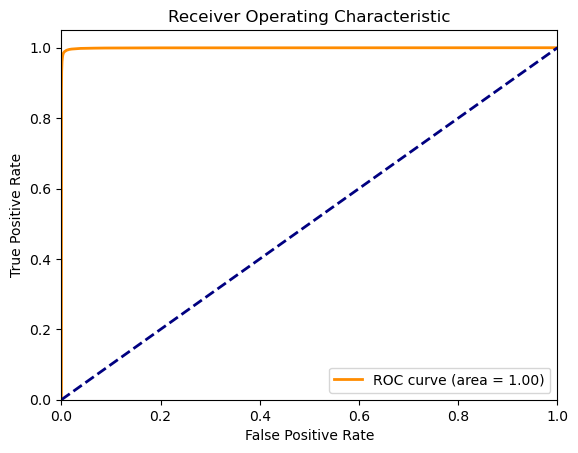

In [7]:
labels_pred_rf_prob = rf.predict_proba(pixels_test_scaled)

fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_rf_prob[:, 1])

roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
with open('random_forest_5.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('scaler_5.pkl', 'wb') as f:
    pickle.dump(scaler, f)